In [ ]:
import torch
print(torch.cuda.is_available())

In [ ]:
import os
from concurrent.futures import ThreadPoolExecutor
import rasterio
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Path to the dataset
DATASET_PATH = "C:/Users/kanuk/OneDrive/Desktop/602project/EuroSAT_MS"

# Function to read a single image and return its metadata
def read_image_metadata(image_path):
    try:
        with rasterio.open(image_path) as src:
            return {
                "file_name": os.path.basename(image_path),
                "width": src.width,
                "height": src.height,
                "count": src.count,  # Number of bands
                "dtype": src.dtypes[0],  # Data type
                "crs": str(src.crs),  # Coordinate reference system
                "transform": src.transform  # Geotransform
            }
    except Exception as e:
        print(f"Error reading {image_path}: {e}")
        return None

# Function to analyze all images in a folder
def analyze_folder(folder_path):
    metadata_list = []
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]
    with ThreadPoolExecutor() as executor:
        results = executor.map(lambda f: read_image_metadata(os.path.join(folder_path, f)), image_files)
        metadata_list.extend([res for res in results if res is not None])
    return metadata_list

# Main function to analyze the dataset
def analyze_dataset(dataset_path):
    dataset_summary = {}
    for folder_name in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder_name)
        if os.path.isdir(folder_path):
            print(f"Analyzing folder: {folder_name}")
            metadata_list = analyze_folder(folder_path)
            dataset_summary[folder_name] = {
                "image_count": len(metadata_list),
                "metadata": metadata_list
            }
    return dataset_summary

# Analyze dataset
dataset_summary = analyze_dataset(DATASET_PATH)

# Print summary
for category, summary in dataset_summary.items():
    print(f"\nCategory: {category}")
    print(f"Image Count: {summary['image_count']}")
    print("Sample Metadata:")
    if summary['metadata']:
        print(summary['metadata'][0])  # Print metadata of the first image

# Plot image size distribution (Optional)
image_sizes = [
    (meta['width'], meta['height'])
    for category in dataset_summary.values()
    for meta in category['metadata']
]
size_counts = Counter(image_sizes)
sizes, counts = zip(*size_counts.items())
plt.bar([f"{w}x{h}" for w, h in sizes], counts)
plt.xticks(rotation=90)
plt.title("Image Size Distribution")
plt.xlabel("Dimensions (Width x Height)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
import os
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split

# Function to normalize pixel values (optional)
def normalize_image(image_path):
    with rasterio.open(image_path) as src:
        data = src.read()  # Read all bands
        normalized_data = data / 65535.0  # Normalize to [0, 1]
        return normalized_data

# Function to prepare the combined dataset
def prepare_combined_dataset(dataset_path, test_size=0.2, val_size=0.1):
    data = []
    labels = []
    categories = os.listdir(dataset_path)
    
    # Assign numeric labels to categories
    label_map = {category: idx for idx, category in enumerate(categories)}
    print(f"Category-to-Label Mapping: {label_map}")
    
    # Load all data and labels
    for category in categories:
        category_path = os.path.join(dataset_path, category)
        if os.path.isdir(category_path):
            print(f"Processing category: {category}")
            for file_name in os.listdir(category_path):
                if file_name.endswith('.tif'):
                    image_path = os.path.join(category_path, file_name)
                    image_data = normalize_image(image_path)  # Normalize the image
                    data.append(image_data)
                    labels.append(label_map[category])  # Assign numeric label
    
    # Convert lists to numpy arrays
    data = np.array(data)
    labels = np.array(labels)
    
    # Split the dataset into train, validation, and test sets
    train_data, test_data, train_labels, test_labels = train_test_split(
        data, labels, test_size=test_size, stratify=labels, random_state=42
    )
    train_data, val_data, train_labels, val_labels = train_test_split(
        train_data, train_labels, test_size=val_size / (1 - test_size), stratify=train_labels, random_state=42
    )
    
    # Print dataset sizes
    print(f"Training set size: {len(train_data)}")
    print(f"Validation set size: {len(val_data)}")
    print(f"Test set size: {len(test_data)}")
    
    return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels), label_map

# Prepare the dataset
(train_data, train_labels), (val_data, val_labels), (test_data, test_labels), label_map = prepare_combined_dataset(DATASET_PATH)

# Example: Access a training sample
print(f"Category Mapping: {label_map}")
print(f"First training sample shape: {train_data[0].shape}, Label: {train_labels[0]}")

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import vgg16
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters
BATCH_SIZE = 16
LEARNING_RATE = 5e-4
EPOCHS = 500
IMG_SIZE = 64
NUM_CHANNELS = 13
TIMESTEPS = 1000

# Define noise schedule
def noise_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    steps = torch.linspace(0, timesteps, timesteps)
    betas = (1 - torch.cos((steps / timesteps) * torch.pi)) / 2 * (beta_end - beta_start) + beta_start
    return betas.clamp(min=1e-8)

# Forward diffusion
def forward_diffusion(x_0, t, betas):
    noise = torch.randn_like(x_0)
    batch_size = x_0.shape[0]
    sqrt_alpha_t = torch.sqrt(1.0 - betas.cumsum(dim=0))[t].view(batch_size, 1, 1, 1)
    sqrt_betas = torch.sqrt(betas[t]).view(batch_size, 1, 1, 1)
    return sqrt_alpha_t * x_0 + sqrt_betas * noise, noise

# Denoising model
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim=32):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, out_channels, 3, padding=1)
        )

    def forward(self, x):
        latent = self.encoder(x)
        return self.decoder(latent)

# Pretrained VGG model for perceptual loss
vgg_model = vgg16(pretrained=True).features[:5]
vgg_model.eval()
for param in vgg_model.parameters():
    param.requires_grad = False

# Custom normalization for VGG
imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
imagenet_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

def normalize_for_vgg(image):
    return (image - imagenet_mean) / imagenet_std

def reduce_channels(image):
    # Reduce 13 channels to 3 channels (e.g., first, middle, last channel)
    return torch.stack([image[:, 0, :, :], image[:, 6, :, :], image[:, 12, :, :]], dim=1)

def perceptual_loss(predicted, target):
    predicted = normalize_for_vgg(reduce_channels(predicted))
    target = normalize_for_vgg(reduce_channels(target))
    predicted_features = vgg_model(predicted)
    target_features = vgg_model(target)
    return ((predicted_features - target_features) ** 2).mean()

# Loss function
def denoising_loss(model, x_0, betas, timesteps):
    t = torch.randint(0, timesteps, (x_0.size(0),), device=x_0.device).long()
    x_t, noise = forward_diffusion(x_0, t, betas)
    predicted_noise = model(x_t)
    mse_loss = ((noise - predicted_noise) ** 2).mean()
    perceptual_component = perceptual_loss(predicted_noise, noise)
    return mse_loss + 0.1 * perceptual_component

# Load dataset
def load_dataset(data, batch_size):
    tensor_data = torch.tensor(data, dtype=torch.float32)
    dataset = TensorDataset(tensor_data)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train model
def train_model(model, train_dataloader, val_dataloader, optimizer, betas, timesteps, device):
    best_val_loss = float("inf")
    early_stop_count = 0
    patience = 10
    loss_history, val_loss_history = [], []

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        for batch_idx, (x,) in enumerate(train_dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            loss = denoising_loss(model, x, betas, timesteps)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_dataloader)
        loss_history.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_x, in val_dataloader:
                val_x = val_x.to(device)
                val_loss += denoising_loss(model, val_x, betas, timesteps).item()
        avg_val_loss = val_loss / len(val_dataloader)
        val_loss_history.append(avg_val_loss)

        print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_diffusion_model.pth")
            print("Saved Best Model")
            early_stop_count = 0
        else:
            early_stop_count += 1

        # Early stopping
        if early_stop_count >= patience:
            print("Early stopping triggered.")
            break

    # Plot loss
    plt.plot(loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Val Loss")
    plt.legend()
    plt.show()

In [ ]:
# Main script
if __name__ == "__main__":
    print(f"Train data shape: {train_data.shape}")
    print(f"Validation data shape: {val_data.shape}")

    betas = noise_schedule(TIMESTEPS).to("cpu")
    model = UNet(in_channels=NUM_CHANNELS, out_channels=NUM_CHANNELS).to("cpu")
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_dataloader = load_dataset(train_data, BATCH_SIZE)
    val_dataloader = load_dataset(val_data, BATCH_SIZE)

    train_model(model, train_dataloader, val_dataloader, optimizer, betas, TIMESTEPS, device="cpu")

Train data shape: (18900, 13, 64, 64)
Validation data shape: (2700, 13, 64, 64)
Epoch 1/500, Train Loss: nan, Val Loss: nan


Load Trained Model

In [16]:
# Load the trained model
model = UNet(in_channels=NUM_CHANNELS, out_channels=NUM_CHANNELS)
model.load_state_dict(torch.load("final_diffusion_model.pth", map_location="cpu"))
model.eval()

UNet(
  (encoder): Sequential(
    (0): Conv2d(13, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 13, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

Generating synthetic images...
NaN detected in model output at step 999
Evaluating synthetic images...
Average SSIM: 0.0063
Average PSNR: 6.2262
Visualizing images...


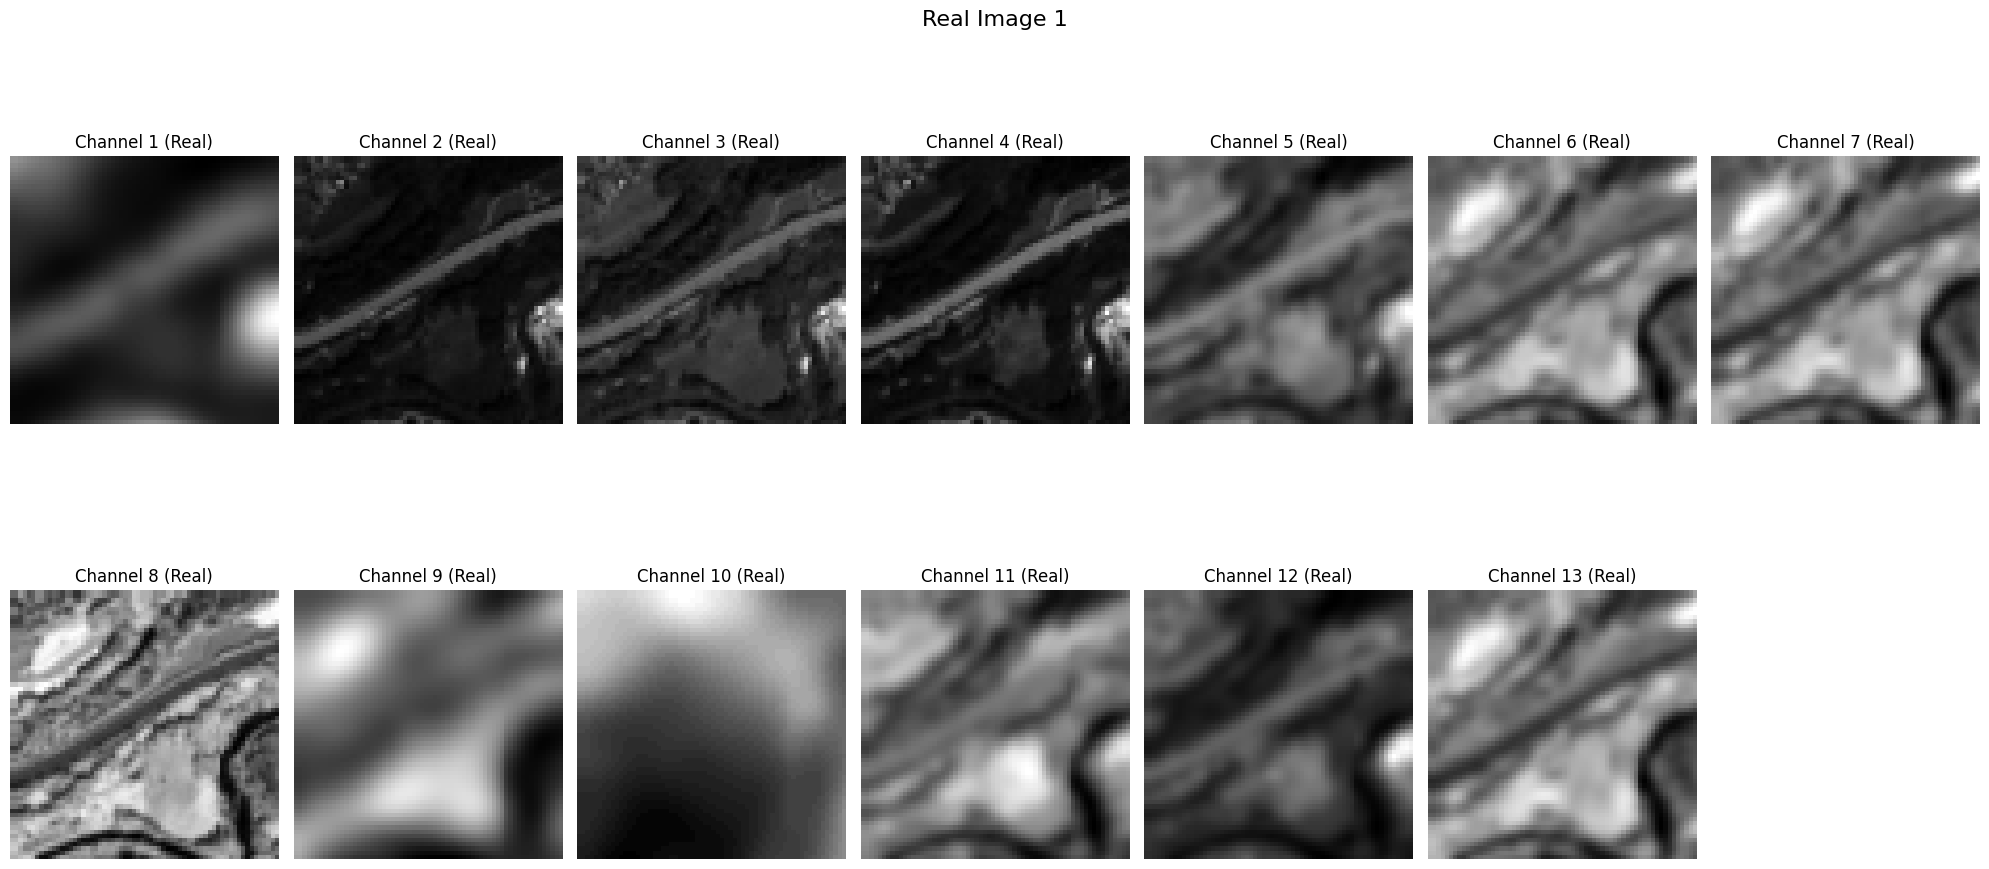

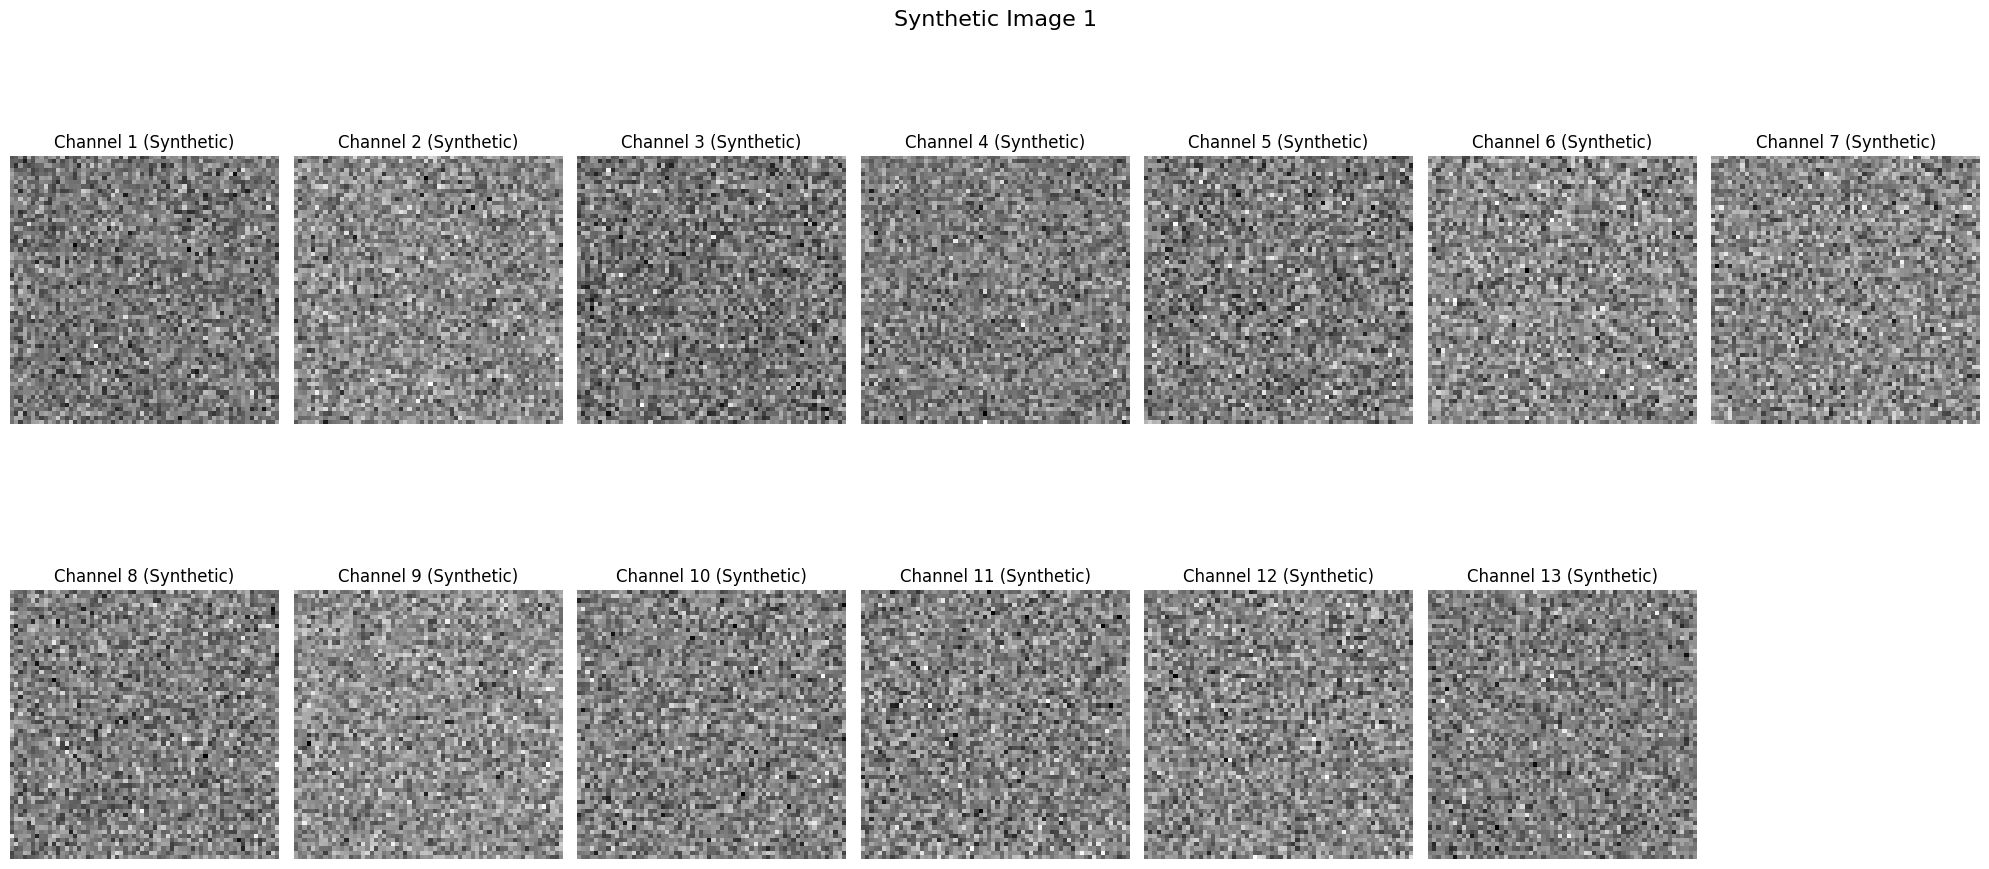

In [24]:
import os
import numpy as np
import torch
import torch.nn as nn
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt

# Ensure GPU or CPU compatibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained model
def load_model(model_path, num_channels):
    model = UNet(in_channels=num_channels, out_channels=num_channels).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

# Generate synthetic images using reverse diffusion
def generate_synthetic_images(model, timesteps, betas, num_samples, img_size, num_channels):
    shape = (num_samples, num_channels, img_size, img_size)
    synthetic_images = reverse_diffusion(model, timesteps, betas, shape, device)
    synthetic_images = (synthetic_images - synthetic_images.min()) / (synthetic_images.max() - synthetic_images.min())
    return synthetic_images.cpu().numpy()

# Evaluate synthetic images
def evaluate_images(real_images, synthetic_images):
    metrics = {"SSIM": [], "PSNR": []}
    for real, synthetic in zip(real_images, synthetic_images):
        real = real.squeeze()  # Remove extra dimensions
        synthetic = synthetic.squeeze()
        metrics["SSIM"].append(ssim(real, synthetic, data_range=1.0))
        metrics["PSNR"].append(psnr(real, synthetic, data_range=1.0))
    avg_ssim = np.mean(metrics["SSIM"])
    avg_psnr = np.mean(metrics["PSNR"])
    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average PSNR: {avg_psnr:.4f}")
    return metrics

# Visualize real and synthetic images
import matplotlib.pyplot as plt

def visualize_images(real_images, synthetic_images, num_samples=1):
    """
    Visualize all channels of real and synthetic images as a grid.
    Args:
    - real_images: Array of real images, shape (num_samples, num_channels, height, width)
    - synthetic_images: Array of synthetic images, shape (num_samples, num_channels, height, width)
    - num_samples: Number of samples to visualize
    """
    for i in range(num_samples):
        # Plot all channels of the real image
        plt.figure(figsize=(20, 10))
        for j in range(real_images.shape[1]):  # Iterate over channels
            plt.subplot(2, (real_images.shape[1] + 1) // 2, j + 1)
            plt.imshow(real_images[i][j], cmap="gray")
            plt.title(f"Channel {j + 1} (Real)")
            plt.axis("off")
        plt.suptitle(f"Noised Image {i + 1}", fontsize=16)
        plt.tight_layout()
        plt.show()

        # Plot all channels of the synthetic image
        plt.figure(figsize=(20, 10))
        for j in range(synthetic_images.shape[1]):  # Iterate over channels
            plt.subplot(2, (synthetic_images.shape[1] + 1) // 2, j + 1)
            plt.imshow(synthetic_images[i][j], cmap="gray")
            plt.title(f"Channel {j + 1} (Synthetic)")
            plt.axis("off")
        plt.suptitle(f"Synthetic Image {i + 1}", fontsize=16)
        plt.tight_layout()
        plt.show()


# Main script
if __name__ == "__main__":
    # Paths and parameters
    MODEL_PATH = "final_diffusion_model.pth"
    NUM_CHANNELS = 13
    IMG_SIZE = 64
    NUM_SAMPLES = 10
    TIMESTEPS = 1000
    betas = noise_schedule(TIMESTEPS).to(device)
    
    # Load model
    model = load_model(MODEL_PATH, NUM_CHANNELS)
    
    # Generate synthetic images
    print("Generating synthetic images...")
    synthetic_images = generate_synthetic_images(model, TIMESTEPS, betas, NUM_SAMPLES, IMG_SIZE, NUM_CHANNELS)
    
    # Evaluate synthetic images
    print("Evaluating synthetic images...")
    real_images = train_data[:NUM_SAMPLES]  # Use a subset of real images for evaluation
    metrics = evaluate_images(real_images, synthetic_images)
    
    # Visualize synthetic images
    print("Visualizing images...")
    visualize_images(real_images, synthetic_images)